- Load Kalman Data
- Load Video
- Align Timestamps\
- align "0" distance from ground plane on kalman\
- For each frame in video, let POS = closest kalman timestep\
- project points from "depth" where depth is render of ground plane - to test this, produce video of ground plane from phone orientation\
- rotate pointcloud and render from above
- use SIFT to transform it into relative position of first image



In [82]:
import os
import cv2
import numpy as np
import cupy as cp
from ultralytics import YOLO
import matplotlib.pyplot as plt
import sys
from PIL import Image
from importlib import reload
import pandas as pd
import plotly.express as px
import gdown
import zipfile

sys.path.insert(1, '..')
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"

In [83]:
files = {
    'walk_to_malachowski' : 'https://drive.google.com/file/d/1EejwRl80fnWIlh9l_YjYTrjQb3d7mMSR/view?usp=drive_link',
    'walk_down_parking_lot' : 'https://drive.google.com/file/d/1RtRjmR7ggn5DgyxNK6mGkihZY-g9NyCq/view?usp=drive_link',
    'malachowski_chamomile' : 'https://drive.google.com/file/d/1V28HPGOMnI-l-GiAFGB5xzt0YajLtwMU/view?usp=drive_link',
    'malachowski_chamomile_2' : 'https://drive.google.com/file/d/1JD9SI-bM44BPeG2frwaznO2Fq97BAmUM/view?usp=drive_link',
    'first_test_walk' : 'https://drive.google.com/file/d/1u7FCFc4uaZscHvZ6wH9wU2pb_Mz9djPF/view?usp=drive_link'
}

def convert_to_direct_download(gdrive_link):
    start = gdrive_link.find('/d/') + 3
    end = gdrive_link.find('/view', start)
    file_id = gdrive_link[start:end]

    direct_download_url = f'https://drive.google.com/uc?id={file_id}&export=download'

    return direct_download_url

# Load Data

In [84]:
# @title Selected File
selected = "walk_to_malachowski" # @param ["malachowski_chamomile", "malachowski_chamomile_2", "walk_to_malachowski", "first_test_walk", "walk_down_parking_lot"]

url = convert_to_direct_download(files[selected])
gdown.download(url, "of.zip")
with zipfile.ZipFile("./of.zip", 'r') as zip_ref:
    zip_ref.extractall("../Data/")

Downloading...
From (original): https://drive.google.com/uc?id=1EejwRl80fnWIlh9l_YjYTrjQb3d7mMSR&export=download
From (redirected): https://drive.google.com/uc?id=1EejwRl80fnWIlh9l_YjYTrjQb3d7mMSR&export=download&confirm=t&uuid=0260c8a7-e60e-4472-8bb3-2ab5fe23975a
To: c:\Users\c1a55\Documents\Roborouter\data\walk_to_malachowski\of.zip
100%|██████████| 536M/536M [00:08<00:00, 62.3MB/s] 


In [85]:
%cd ../data/
%cd $selected

c:\Users\c1a55\Documents\Roborouter\data\data
c:\Users\c1a55\Documents\Roborouter\data\data\walk_to_malachowski


In [142]:
AccelerometerDF = pd.read_csv('Accelerometer.csv')
print("🔴Accelerometer:")
print(AccelerometerDF.head(1))
#east   //in m/s^2
#north  //in m/s^2
#up     //in m/s^2

BarometerDF = pd.read_csv('Barometer.csv')
print("🔵Barometer:")
print(BarometerDF.head(1))
#relativeAltitude //in meters

LocationDF = pd.read_csv('Location.csv')
print("🟢Location:")
print(LocationDF.head(1))
#up                 //(in meters)
#speedAccuracy      //in m/s
#bearingAccuracy    //in degrees
#east               //(in meters)
#bearing            //direction of travel since last data point (might be redundant to fuse?)
#horizontalAccuracy //which is in meters
#verticalAccuracy   //also in meters
#north              //(in meters)
#speed              //velocity along the bearing provided

#To be used for synchronization
MicrophoneDF = pd.read_csv('Microphone.csv')
#print("Microphone:")
#print(MicrophoneDF.head(1))
#dBFS

#Prefused = best guess. Smoothing welcomed.
OrientationDF = pd.read_csv('Orientation.csv')
print("🟠Orientation:")
print(OrientationDF.head(1))
#yaw
#qx
#qz
#roll
#qw
#qy
#pitch

🔴Accelerometer:
                  time  seconds_elapsed         z         y         x
0  1707585936836849400         0.120849 -1.105513  0.109932 -0.172708
🔵Barometer:
                  time  seconds_elapsed  relativeAltitude     pressure
0  1707585936256298000        -0.459702               0.0  1016.647186
🟢Location:
                  time  seconds_elapsed  altitude  speedAccuracy  \
0  1707585908244470000        -28.47153  6.276319       1.207736   

   bearingAccuracy   latitude  altitudeAboveMeanSeaLevel  bearing  \
0             -1.0  29.644654                  35.686319     -1.0   

   horizontalAccuracy  verticalAccuracy  longitude     speed  
0            4.758735          3.343498 -82.345984  0.132651  
🟠Orientation:
                  time  seconds_elapsed       yaw        qx        qz  \
0  1707585936836849400         0.120849 -0.543345 -0.028643  0.269779   

       roll        qw        qy     pitch  
0 -0.096052 -0.960761  0.057768  0.086314  


(145, 12)
(132, 4)
(14492, 5)


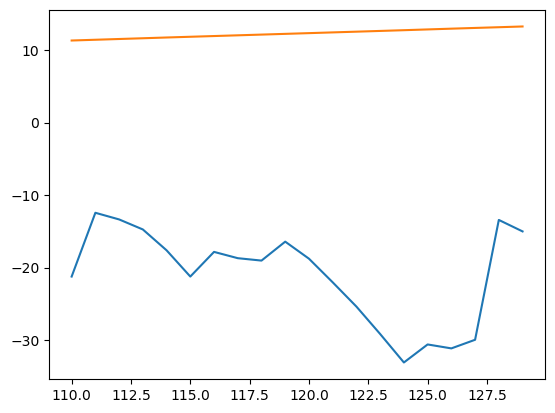

In [143]:
# Sync microphone tinmings with video playback:
videoPlaybackClapTimestamp = 3 + 24.5/30
#30fps, clap spotted at ~24/25 frames after 3 seconds elapsed, so clap two in malachowski occurs at video time of (3 + 24.5/30)

plt.plot((MicrophoneDF[['dBFS', 'seconds_elapsed']][110:130]))
#looks like the clap occurs at around index 123 to 126
#print(MicrophoneDF['seconds_elapsed'][110:130])

#indeed, seems all our stuff starts around 12.5 seconds elapsed
secondsElapsedSync = 12.5

LocationDF = LocationDF[LocationDF['seconds_elapsed'] >= 12.5]
BarometerDF = BarometerDF[BarometerDF['seconds_elapsed'] >= 12.5]
AccelerometerDF = AccelerometerDF[AccelerometerDF['seconds_elapsed'] >= 12.5]
OrientationDF = OrientationDF[OrientationDF['seconds_elapsed'] >= 12.5]

print(LocationDF.shape)
print(BarometerDF.shape)
print(AccelerometerDF.shape)


In [88]:
from scipy.spatial.transform import Rotation as R
pi = np.pi


ax, ay, az = 30, 0, 30  # Example acceleration vector
qx, qy, qz, qw = -0.07, -0.4, -0.06, 0.9  # Example quaternion (no rotation)


def convert_xyz_acceleration_to_NEU(ax, ay, az, qx, qy, qz, qw):
  Rquat = R.from_quat([qx, qy, qz, qw])
  rotation_matrix = Rquat.as_matrix()
  inv = rotation_matrix.T
  result = inv @ [ax, ay, az]
  return result

convert_xyz_acceleration_to_NEU(ax, ay, az, qx, qy, qz, qw)
#definitely correct as fuck.

array([       42.3,      2.6367,     -1.9285])

## Convert accelerations using orientation dataframe

In [144]:
#Preprocessing the accelerations into ENU accelerations using the phone rotation:
def process_row(row, orient_df):
    ax, ay, az = row['x'], row['y'], row['z']
    ori_row = orient_df.loc[row.name]  # Assumes same index in orient_df as in accel_df

    qw, qx, qy, qz = ori_row['qw'], ori_row['qx'], ori_row['qy'], ori_row['qz']
    north, east, up = convert_xyz_acceleration_to_NEU(ax, ay, az, qx, qy, qz, qw)

    return pd.Series([north, east, up], index=['north', 'east', 'up'])

def convert_accelerations(accel_df, orient_df):
    result_df = accel_df.copy()
    result_df.rename(columns={'x': 'north', 'y': 'east', 'z': 'up'}, inplace=True)
    transformations = accel_df.apply(process_row, axis=1, args=(orient_df,))  # Apply row-wise
    result_df[['north', 'east', 'up']] = transformations  # Update the result DataFrame
    return result_df



print(AccelerometerDF.head(3))
AccelerometerENUDF=convert_accelerations(AccelerometerDF, OrientationDF)
print(AccelerometerENUDF.head(3))

                     time  seconds_elapsed         z         y         x
1235  1707585949218205400        12.502205 -0.134372  0.073516 -0.056918
1236  1707585949228230400        12.512230 -0.087288  0.058662 -0.098186
1237  1707585949238256400        12.522256 -0.085665  0.085258 -0.079662
                     time  seconds_elapsed        up      east     north
1235  1707585949218205400        12.502205 -0.130516  0.013886 -0.097328
1236  1707585949228230400        12.512230 -0.078243 -0.016237 -0.119646
1237  1707585949238256400        12.522256 -0.080218  0.016169 -0.119403


## Just visualizing the integrated acceleration data.
Its not great, but it does represent the course

In [159]:
def integrate_acceleration_to_position(df):
    # Reset index to ensure consistent positional indexing
    df = df.reset_index(drop=True)
    
    # Calculate the differences in time to get dt
    dt = df['seconds_elapsed'].diff().fillna(0)  # Using fillna(0) for the first value
    
    # Initialize columns for velocity and position
    for axis in ['up', 'east', 'north']:
        df[f'velocity_{axis}'] = 0
        df[f'position_{axis}'] = 0
    
    # Calculate velocity and position using the trapezoidal rule for integration
    for i in range(1, len(df)):
        for axis in ['up', 'east', 'north']:
            # Integrate acceleration to find velocity
            df.loc[i, f'velocity_{axis}'] = (
                df.loc[i-1, f'velocity_{axis}'] + 
                0.5 * (df.loc[i, axis] + df.loc[i-1, axis]) * dt.iloc[i]
            )
            
            # Integrate velocity to find position
            df.loc[i, f'position_{axis}'] = (
                df.loc[i-1, f'position_{axis}'] + 
                0.5 * (df.loc[i, f'velocity_{axis}'] + df.loc[i-1, f'velocity_{axis}']) * dt.iloc[i]
            )
    
    # Select only the position columns for the result
    position_columns = [col for col in df.columns if 'position' in col]
    return df[position_columns]

int_location_df = integrate_acceleration_to_position(AccelerometerENUDF)

fig = px.line_3d(
    int_location_df,
    x=int_location_df['position_north'],
    y=int_location_df['position_east'],
    z=int_location_df['position_up']
)
fig.layout.scene.aspectmode='data'
fig.show()

In [162]:
import pymap3d as pm
lat0 = LocationDF.iloc[0]['latitude']  # deg
lon0 = LocationDF.iloc[0]['longitude']  # deg
h0 = LocationDF.iloc[0]['altitude']     # meters

def convert_to_enu(row):
    # Conversion using scalar reference points
    (east, north, up) = pm.geodetic2enu(row['latitude'], row['longitude'], row['altitude'], lat0, lon0, h0)
    return pd.Series([east, north, up], index=['east', 'north', 'up'])

# Apply the function to each row and create new columns
LocationENUDF = LocationDF.copy()
LocationENUDF[['east', 'north', 'up']] = LocationDF.apply(convert_to_enu, axis=1)

# Show first few results
print(LocationENUDF[['east', 'north', 'up']].head(3))

# Visualization using Plotly Express
fig = px.line_3d(LocationENUDF, x='north', y='east', z='up', title='3D Trajectory in ENU Coordinates')
fig.layout.scene.aspectmode='data'
fig.show()


        east     north        up
14  0.000000  0.000000  0.000000
15 -0.119395  0.027304 -0.117257
16 -0.119395  0.027304 -0.117257


# Perform Kalman Filtering

In [194]:
#AccelerometerENUDF
#BarometerDF

import numpy as np
from filterpy.kalman import KalmanFilter
from torch import norm

kf = KalmanFilter(dim_x=6, dim_z=3)  # 9 for pos, vel, acc; adjust dim_z based on measurements

kf.x = (np.zeros(6)) #Initialize to 0 velocity, acceleration, position
kf.P = np.eye(6) * 1  # Initialize with a large uncertainty in initial state

kf.F = np.eye(6) #will be updated per below
def update_F(dt):
    # Update the transition matrix according to the new time delta `dt`
    # Assuming a simple kinematic model where position and velocity are affected by acceleration
    F = np.array([[1, 0, 0, 0.5*dt**2, 0, 0],  # pos_east update
                  [0, 1, 0, 0, 0.5*dt**2, 0],  # pos_north update
                  [0, 0, 1, 0, 0, 0.5*dt**2],  # pos_up update
                  [0, 0, 0, 1, 0, 0],           # acc_east constant
                  [0, 0, 0, 0, 1, 0],           # acc_north constant
                  [0, 0, 0, 0, 0, 1]])          # acc_up constant
    kf.F = F

kf.Q = np.eye(6) * 0.1  # Adjust this value based on the expected process noise (unsure)

# Placeholder for measurement matrix (H) and measurement noise covariance (R)
kf.H = np.eye(3, 6)  
kf.R = np.eye(3)     


def gps_measurement_matrix():
    # Assuming we measure position directly
    H = np.zeros((3, 6))
    H[0, 0] = 1  # Measure east position
    H[1, 1] = 1  # Measure north position
    H[2, 2] = 1  # Measure up position
    return H

# Accelerometer measurements
def accel_measurement_matrix():
    # Assuming we measure the second derivative of position (acceleration)
    H = np.zeros((3, 6))
    H[0, 3] = 1  # Acceleration east
    H[1, 4] = 1  # Acceleration north
    H[2, 5] = 1  # Acceleration up
    return H

def barometer_measurement_matrix():
    # Assuming we measure the altitude directly
    H = np.zeros((1, 6))
    H[0, 2] = 1  # Measure up position (altitude)
    return H


LocationENUDF['sensor_type'] = 'GPS'
AccelerometerENUDF['sensor_type'] = 'Accelerometer'
BarometerDF['sensor_type'] = 'Barometer'

merged_df = pd.concat([LocationENUDF, AccelerometerENUDF, BarometerDF], ignore_index=True)
merged_df.sort_values('seconds_elapsed', inplace=True)
merged_df.reset_index(drop=True, inplace=True)

last_time = {'GPS': 0, 'Accelerometer': 0, 'Barometer': 0}
dict = {'seconds_elapsed':[], 'east':[], 'north':[], 'up':[]}
outputCoords = pd.DataFrame(dict)
for index, row in merged_df.iterrows():
    sensor_type = row['sensor_type']
    current_time = row['seconds_elapsed']
    
    # Calculate dt using the last timestamp for the current sensor type
    if last_time[sensor_type] == 0:  # If it's the first measurement of this type
        dt = 0  # There's no previous measurement to compare to
    else:
        dt = current_time - last_time[sensor_type]
    
    # Update the last_time for the current sensor type
    last_time[sensor_type] = current_time
    print(dt, " ", sensor_type)

    # Update the state transition matrix for the new dt
    update_F(dt)

    if row['sensor_type'] == 'Accelerometer':
        kf.dim_z = 3 
        kf.H = accel_measurement_matrix()
        kf.R = np.eye(3) * np.sqrt((row['east']**2 + row['north']**2 + row['up']**2))*10000  # Assume constant accelerometer noise; adjust as necessary
        measurement = np.array([row['east'], row['north'], row['up']])
        kf.update(measurement)
    elif row['sensor_type'] == 'GPS':
        kf.dim_z = 3 
        kf.H = gps_measurement_matrix()
        kf.R = np.diag([row['horizontalAccuracy'], row['horizontalAccuracy'], row['verticalAccuracy']])*0.0001
        measurement = np.array([row['east'], row['north'], row['up']])
        print("🚨🚨🚨", measurement)
        kf.update(measurement)
    # elif row['sensor_type'] == 'Barometer':
    #     kf.dim_z = 1
    #     kf.H = barometer_measurement_matrix() 
    #     kf.R = 0.5
    #     measurement = np.array([row['relativeAltitude']]).reshape(-1, 1)
    #     kf.update(measurement)

    # Optional: Save or display the filter's state
    print("Updated state:", kf.x, " ", row["sensor_type"])
    outputCoords.loc[len(outputCoords.index)] = [current_time , *kf.x[0:3]]

# Add a 'source' column to each DataFrame to distinguish them in the plot
LocationENUDF['source'] = 'GPS'
outputCoords['source'] = 'Kalman Filter'

# Combine the two DataFrames
combined_df = pd.concat([LocationENUDF.rename(columns={'east': 'Y', 'north': 'X', 'up': 'Z'}),
                         outputCoords.rename(columns={'east': 'Y', 'north': 'X', 'up': 'Z'})])

# Plot using Plotly Express
fig = px.line_3d(combined_df, x='X', y='Y', z='Z', color='source')
fig.layout.scene.aspectmode='data'
fig.show()

0   Accelerometer
Updated state: [          0           0           0  8.4931e-06 -5.9527e-05 -7.9826e-05]   Accelerometer
0.010025146484373693   Accelerometer
Updated state: [          0           0           0 -2.7832e-06 -0.00014254 -0.00013408]   Accelerometer
0.01002587890624973   Accelerometer
Updated state: [          0           0           0  8.3662e-06 -0.00022476  -0.0001893]   Accelerometer
0.010025146484375469   Accelerometer
Updated state: [          0           0           0   4.097e-05 -0.00029354 -0.00025343]   Accelerometer
0.010026123046875668   Accelerometer
Updated state: [          0           0           0  0.00010078 -0.00034447  -0.0003133]   Accelerometer
0.010025634765625568   Accelerometer
Updated state: [          0           0           0  5.8252e-05 -0.00036265 -0.00022506]   Accelerometer
0.01002539062499963   Accelerometer
Updated state: [          0           0           0  6.7473e-05 -0.00039839 -0.00013275]   Accelerometer
0.01002587890624973   Accel

In [ ]:
delta_t = 1/100  # Time step for 100Hz frequency
initial_state = np.zeros(6)  # [east_pos, north_pos, up_pos, east_vel, north_vel, up_vel]
transition_matrix = np.array([
    [1, 0, 0, delta_t, 0, 0],
    [0, 1, 0, 0, delta_t, 0],
    [0, 0, 1, 0, 0, delta_t],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1]
])

state_covariance = np.eye(6) * 100
state_covariance_combined = np.eye(6) * 100
process_noise = np.eye(6) * 0.01 

average_acceleration = AccelerometerENUDF[['east', 'north', 'up']].abs().mean()
measurement_noise_accel = np.array([
    [average_acceleration['east']*.01, 0, 0], #Iphone docs say 1% measurement error. We crank artificially
    [0, average_acceleration['north']*.01, 0],
    [0, 0, average_acceleration['up']*.01],
])
measurement_noise_gps = np.eye(3) * 3  # GPS measurement noise
observation_matrix_accel = np.array([
    [0, 0, 0, 1, 0, 0],  # east_pos
    [0, 0, 0, 0, 1, 0],  # north_pos
    [0, 0, 0, 0, 0, 1],  # up_pos
])

observation_matrix_gps = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

measurement_noise_combined = np.block([
    [measurement_noise_gps, np.zeros((3, 3))],
    [np.zeros((3, 3)), measurement_noise_accel]
])

observation_matrix_combined = np.block([
    [observation_matrix_gps, np.zeros((3, 3))],
    [np.zeros((3, 3)), np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        ])
     ]
])

state = np.zeros(6)

dict = {'east':[], 'north':[], 'up':[]}
outputCoords = pd.DataFrame(dict)
print(AccelerometerENUDF.shape)
# Kalman filter loop
for index, accel_row in enumerate(zip(AccelerometerENUDF.iterrows())):
    print(f"Before update: State (velocities) = {state[3:]}")
    # Update state and state covariance here based on the transition matrix and process noise
    state = transition_matrix.dot(state)
    state_covariance = transition_matrix.dot(state_covariance).dot(transition_matrix.T) + process_noise

    if index % 100 == 0:
        print("GPS Update 🚨")
        # GPS data is available
        try:
            loc_row = LocationENUDF.iloc[index // 100]
        except Exception as e:
            print(e)
            break
        observation_vector = np.concatenate((np.array([loc_row['east'], loc_row['north'], loc_row['up']]), np.array([accel_row[0][1]['east'], accel_row[0][1]['north'], accel_row[0][1]['up']])))
        observation_matrix = observation_matrix_combined
        measurement_noise = measurement_noise_combined
        S = observation_matrix.dot(state_covariance).dot(observation_matrix.T) + measurement_noise  # 6x6 matrix
        K = state_covariance.dot(observation_matrix.T).dot(np.linalg.inv(S))  # K will be 6x6
    else:
        # Only accelerometer data is available
        observation_vector = np.array([accel_row[0][1]['east'], accel_row[0][1]['north'], accel_row[0][1]['up']])
        observation_matrix = observation_matrix_accel
        measurement_noise = measurement_noise_accel

        S = observation_matrix.dot(state_covariance).dot(observation_matrix.T) + measurement_noise  # 3x3 matrix for accel
        K = state_covariance.dot(observation_matrix.T).dot(np.linalg.inv(S))  # K will be 6x3 for accel


    state = state + K.dot(observation_vector - observation_matrix.dot(state))

    # Update state covariance
    state_covariance = (np.eye(len(state)) - K.dot(observation_matrix)).dot(state_covariance)

    outputCoords.loc[len(outputCoords.index)] = state[0:3]
    print(f"After update: State (velocities) = {state[3:]}")

In [179]:
# Add a 'source' column to each DataFrame to distinguish them in the plot
LocationENUDF['source'] = 'GPS'
outputCoords['source'] = 'Kalman Filter'

# Combine the two DataFrames
combined_df = pd.concat([LocationENUDF.rename(columns={'east': 'Y', 'north': 'X', 'up': 'Z'}),
                         outputCoords.rename(columns={'east': 'Y', 'north': 'X', 'up': 'Z'})])

# Plot using Plotly Express
fig = px.line_3d(combined_df, x='X', y='Y', z='Z', color='source')
fig.layout.scene.aspectmode='data'
fig.show()

In [ ]:
print(outputCoords.head(5)) #east north up source
print(OrientationDF.head(5))

print(outputCoords.shape)
print(OrientationDF.shape)




       east     north        up         source
0 -0.000026 -0.000090 -0.000314  Kalman Filter
1 -0.000931 -0.003184 -0.011085  Kalman Filter
2 -0.001901 -0.004427 -0.020805  Kalman Filter
3 -0.003873 -0.003195 -0.027016  Kalman Filter
4 -0.007485 -0.000608 -0.028050  Kalman Filter
                  time  seconds_elapsed       yaw        qx        qz  \
0  1707585936836849400         0.120849 -0.543345 -0.028643  0.269779   
1  1707585936846874400         0.130874 -0.545215 -0.030435  0.270720   
2  1707585936856900400         0.140900 -0.547201 -0.032495  0.271718   
3  1707585936866925600         0.150926 -0.549221 -0.034340  0.272721   
4  1707585936876950500         0.160950 -0.551121 -0.035765  0.273654   

       roll        qw        qy     pitch  
0 -0.096052 -0.960761  0.057768  0.086314  
1 -0.094900 -0.960445  0.057710  0.089830  
2 -0.093506 -0.960102  0.057607  0.093840  
3 -0.092129 -0.959762  0.057459  0.097411  
4 -0.090964 -0.959453  0.057302  0.100158  
(15727, 4)
(157